In [1]:
import pandas as pd
import os
import sys
import pickle
import gzip
print(os.getcwd())

/home/mg/ChimeraProject/scripts


In [ ]:
def ramka(local_vars,brek=1000):
    dik = {var: sys.getsizeof(obj) for var, obj in local_vars}
    dik = dict(reversed(sorted(dik.items(), key=lambda item: item[1])))
    #print(dik)
    max_key_length = max(len(key) for key in dik)
    stri="_______________________  GB  MB  KB   B"
    c=1
    for key, value in dik.items():
        c+=1
        if c == brek:break
        stri= stri + "\n"+(f'{key.ljust(max_key_length)}: {format(value, ",").replace(",", " "):>15}')
    return stri, dik
print(ramka(list(globals().items()),brek=15)[0])
#ramka(list(globals().items()),brek=15)[1]["str_seq"],ramka(list(globals().items()),brek=15)[1]["seq"]

_______________________  GB  MB  KB   B
_i2               :             684
ramka             :             160
open              :             160
_i1               :             126
_i                :             126
In                :             120
_ih               :             120
__doc__           :             105
__vsc_ipynb_file__:              81
gzip              :              72
pickle            :              72
sys               :              72
os                :              72


In [3]:
def dicart_kmers_with_low_abund(data, threshold):
    """
    Filters kmers with low abundance.
    Retains only the most abundant kmers contributing to a specified percentage
    of the total abundance.
    Args:
        threshold (float): Percentage of total abundance to retain.
    Returns:
        dict: Filtered `kmer_array` and `index_array`.
    """
    import numpy as np
    subarray_lengths = np.array([len(subarray) for subarray in data["index_array"]])
    unique_lengths, counts = np.unique(subarray_lengths, return_counts=True)
    sorted_indices = np.argsort(unique_lengths)[::-1]
    sorted_lengths = unique_lengths[sorted_indices]
    max_length = sorted_lengths[0]
    min_length = threshold * max_length
    good_indices = np.where(subarray_lengths >= min_length)[0]
    new_data = {
        "kmer_array": data["kmer_array"][good_indices],
        "index_array": data["index_array"][good_indices],}
    return new_data

In [39]:
import numpy as np
import os

different_thres_dict = {}
pickle_folder = os.path.join('..', 'pickles', 'uchime_ITS2', 'genus_uchime', 'all15mers')
file_names = os.listdir(pickle_folder)
lenka = len(file_names)
# Preload all the data
preloaded_data = {}
for n, file_name in enumerate(file_names):
    if n % 50 == 0: 
        print(f"Loading data... {n}/{lenka}{" "*20}", end="\r")
    file_path = os.path.join(pickle_folder, file_name)
    data = np.load(file_path, allow_pickle=True)
    preloaded_data[file_name] = data
# Now process the data for each threshold
for threshold in [0,0.025,0.05,0.075,0.1,0.15, 0.2, 0.22,0.25, 0.3, 0.4, 0.5, 0.6]:
    taxa_kmer_abund_dict = {}
    for n, file_name in enumerate(file_names):
        if n % 50 == 0: 
            print(f"{threshold}, {n}/{lenka}{" "*20}", end="\r")
        data = preloaded_data[file_name]
        new_data = dicart_kmers_with_low_abund(data, threshold)  # Apply function
        # Store results in dictionary with meaningful names
        taxa_kmer_abund_dict[file_name.split(".npz")[0].split("/")[-1]] = new_data
    
    different_thres_dict[threshold] = taxa_kmer_abund_dict

#### Now I have for each Genus Kmers with their positions in reads in that genus and I have discarted kmers with low abundace in all reads in that genus

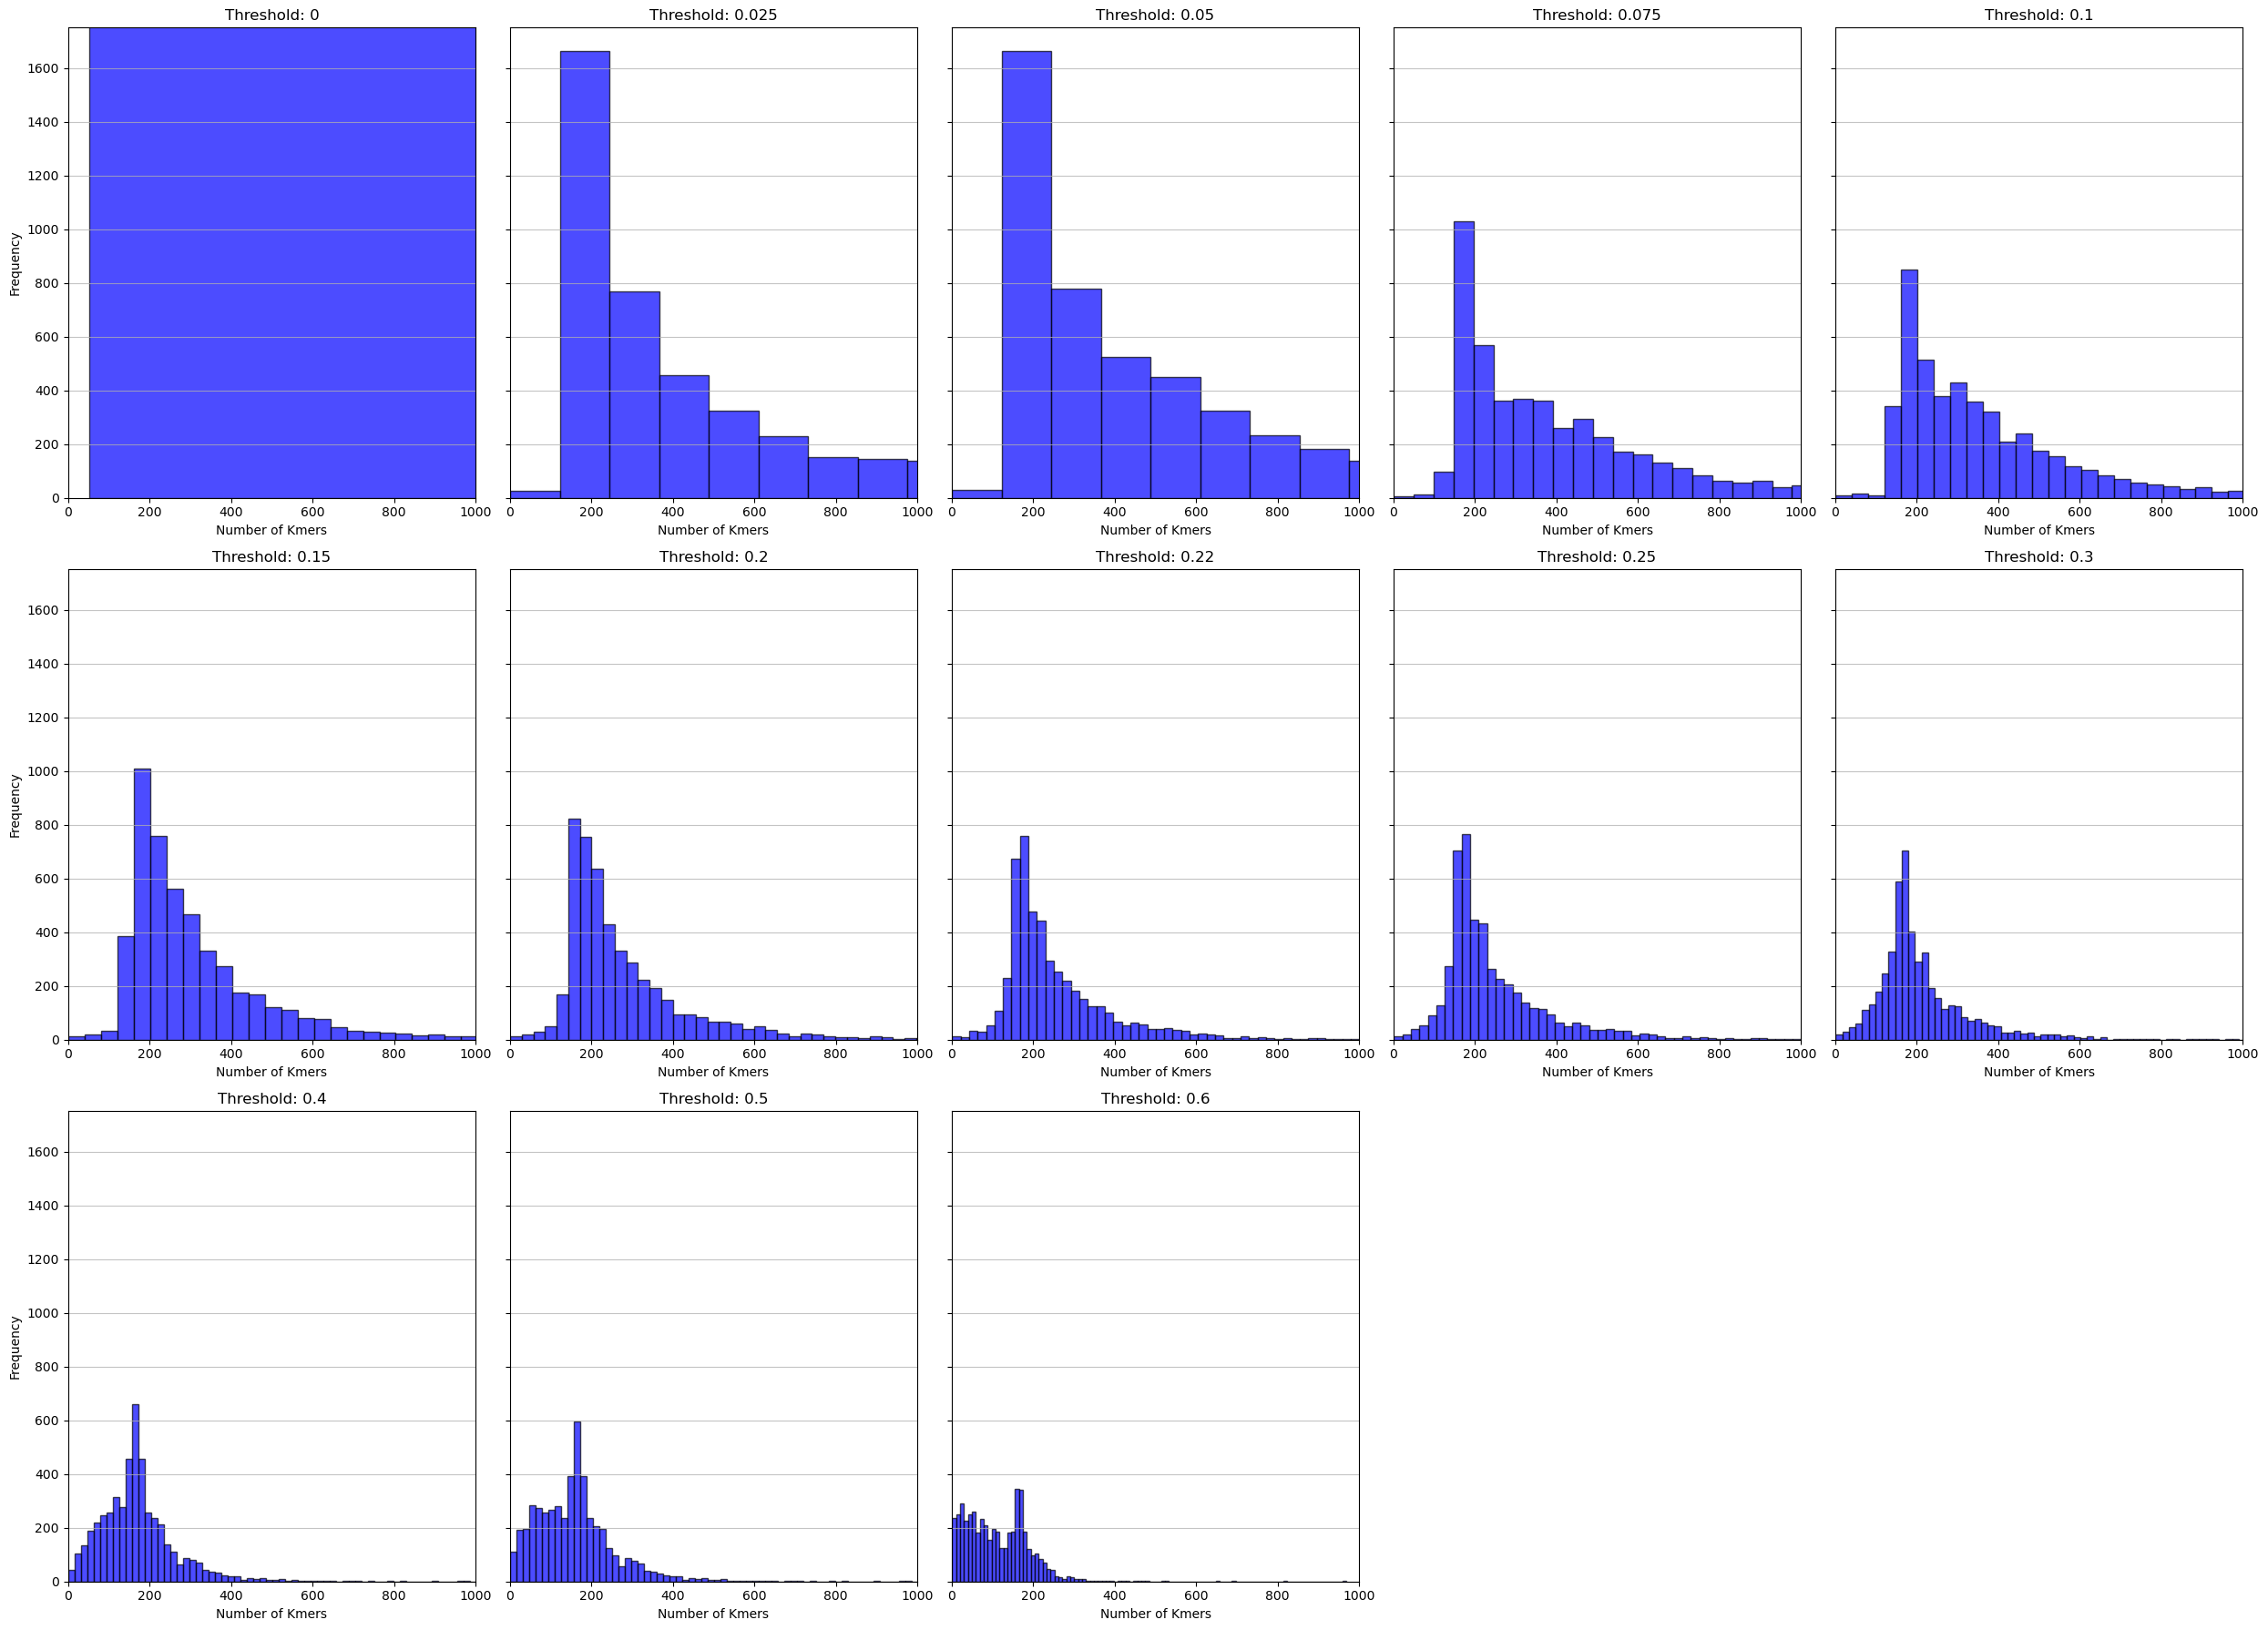

In [41]:
# plot of the number of kmers in each genus

import matplotlib.pyplot as plt

# Create subplots for each threshold - filtering out theless abundant kmers
thresholds = sorted(different_thres_dict.keys())
num_thresholds = len(thresholds)
rows = 3
cols = (num_thresholds + rows - 1) // rows  # Calculate the number of columns needed
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 6 * rows), sharey=True)

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Fixed max value for x-axis
fixed_x_max = 1000
fixed_y_max = 1750
# Plot histograms for each threshold
for i, threshold in enumerate(thresholds):
    # Compute key_counts for the current threshold
    key_counts = {key: len(value["kmer_array"]) for key, value in different_thres_dict[threshold].items()}
    values = list(key_counts.values())
    
    # Plot the histogram
    axes[i].hist(values, bins=100, color='blue', alpha=0.7, edgecolor='black')
    axes[i].set_title(f'Threshold: {threshold}')
    axes[i].set_xlabel('Number of Kmers')
    axes[i].set_xlim(0, fixed_x_max)  # Set the x-axis limit to 0 to 1600
    axes[i].set_ylim(0, fixed_y_max)
    if i % cols == 0:  # Set ylabel only for the first column
        axes[i].set_ylabel('Frequency')
    
    axes[i].grid(axis='y', alpha=0.75)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [44]:
log_of_discarted_kmers_per_threshold = {}
for threshold in different_thres_dict.keys():
    taxa_kmer_abund_dict = different_thres_dict[threshold]
    all_kmers_ever = sum([len([km for km in i["kmer_array"]]) for i in taxa_kmer_abund_dict.values()])
    all_mean_index_ever = np.mean([np.mean([np.mean(ix) for ix in i["index_array"]]) for i in taxa_kmer_abund_dict.values()])
    all_min_index_ever = np.mean([np.mean([np.min(ix) for ix in i["index_array"]]) for i in taxa_kmer_abund_dict.values()])
    all_max_index_ever = np.mean([np.mean([np.max(ix) for ix in i["index_array"]]) for i in taxa_kmer_abund_dict.values()])
    kmers_with_0_position = sum([sum([1 for ix in i["index_array"] if np.max(ix) == 0]) for i in taxa_kmer_abund_dict.values()])
    kmers_with_less50_position = sum([sum([1 for ix in i["index_array"] if np.mean(ix) <50]) for i in taxa_kmer_abund_dict.values()])
    kmers_with_less10_position = sum([sum([1 for ix in i["index_array"] if np.mean(ix) <10]) for i in taxa_kmer_abund_dict.values()])
    no_of_taxa_with_1_kmer = sum([1 for i in taxa_kmer_abund_dict.values() if len(i["kmer_array"]) == 1])
    no_of_taxa_with_less10_kmers = sum([1 for i in taxa_kmer_abund_dict.values() if len(i["kmer_array"]) < 10])
    no_of_taxa_with_0_kmers = sum([1 for i in taxa_kmer_abund_dict.values() if len(i["kmer_array"]) ==0])
    
    #print(all_kmers_ever,all_min_index_ever,all_max_index_ever,all_mean_index_ever)
    log_of_discarted_kmers_per_threshold[threshold] = {
        "all_kmers_ever": all_kmers_ever,
        "all_mean_index_ever": all_mean_index_ever,
        "all_min_index_ever": all_min_index_ever,
        "all_max_index_ever": all_max_index_ever,
        "kmers_with_0_position": kmers_with_0_position,
        "kmers_with_less50_position": kmers_with_less50_position,
        "kmers_with_less10_position": kmers_with_less10_position,
        "no_of_taxa_with_1_kmer": no_of_taxa_with_1_kmer,
        "no_of_taxa_with_less10_kmers": no_of_taxa_with_less10_kmers,
        "no_of_taxa_with_0_kmers": no_of_taxa_with_0_kmers,
    }
    #break
    

In [48]:
for threshold in different_thres_dict.keys():
    taxa_kmer_abund_dict = different_thres_dict[threshold]
    no_of_kmers_with_abundance_1 = sum([sum([1 for ix in i["index_array"] if len(ix) == 1]) for i in taxa_kmer_abund_dict.values()])

    log_of_discarted_kmers_per_threshold[threshold]["no_of_kmers_with_abundance_1"] = no_of_kmers_with_abundance_1

In [ ]:
import matplotlib.pyplot as plt
import math

# Extract thresholds
thresholds = sorted(log_of_discarted_kmers_per_threshold.keys())

# Get all keys from the first threshold's dictionary
keys = list(log_of_discarted_kmers_per_threshold[thresholds[0]].keys())

# Determine the number of rows and columns for the grid
num_keys = len(keys)
num_cols = math.ceil(num_keys / 2)  # 2 rows, so divide keys into columns

# Create the figure
plt.figure(figsize=(15, 10))

# Plot each key
for i, key in enumerate(keys):
    # Extract values for the current key across all thresholds
    values = [
        log_of_discarted_kmers_per_threshold[threshold][key]
        for threshold in thresholds
    ]
    
    # Create a subplot for the current key
    plt.subplot(2, num_cols, i + 1)
    plt.plot(thresholds, values, marker="o", linestyle="-", label=key)
    plt.title(f"{key} Across Thresholds")
    plt.xlabel("Threshold")
    plt.ylabel(key)
    #plt.yscale("log")
    plt.grid(True)
    plt.legend()

# Adjust layout
plt.tight_layout()
plt.show()

: 

In [67]:
# best threshold is 0.2
taxa_kmer_abund_dict = different_thres_dict[0.2]
#del(different_thres_dict)

### So I have discarted kmers with that are in the last quartile juding from its abundance - this will filter out kmers with low abundace reads per each genus and it also removes all those kmers with abundance of 1 - these are probably mistakes

In [ ]:
from Bio import SeqIO
origi_sequences_for_simera = [(record.id, str(record.seq)) for record in SeqIO.parse("../datasets/uchime_reference_dataset_16_10_2022/2022_10_26_chimera_reference_release/ITS1_ITS2_datasets/uchime_reference_dataset_16_20_2022_ITS2.fasta", "fasta")]
genus_read_count = [i for i in origi_sequences_for_simera if "g__Cladophialophora" in i[0]]
len(genus_read_count),genus_read_count[:2] # there were 13 reads of genus Zymoseptoria

(1888,
 [('Cladophialophora_sp|UDB02869914|SH0901951.09FU|reps|k__Fungi;p__Ascomycota;c__Eurotiomycetes;o__Chaetothyriales;f__Herpotrichiellaceae;g__Cladophialophora;s__Cladophialophora_sp',
   'GTTCGAGCGTCATTTTCACTCCCTCAGGCCTCCTGGCCTTGGTGTTGGACGGCTTGGTTTTGGTGACAGAACCCCTCCGAAAGTGAATGACGGCGGCCTGTGGGACCCCCGGTACACTGAGCTTCTTTGATCGAGCACGTATCGGTTTTTAAAGGGTGGACAGGACCCGGTCTTCTTCCTTGACTGGAAACAATCCATTTTCCAAA'),
  ('Cladophialophora_sp|UDB02885146|SH0901952.09FU|reps|k__Fungi;p__Ascomycota;c__Eurotiomycetes;o__Chaetothyriales;f__Herpotrichiellaceae;g__Cladophialophora;s__Cladophialophora_sp',
   'GTTCGAGCGTCATTATCACCCCTCAAGCCCCTGGCTTGGTGTTGGACGGTTTGGTTTTGGCAACAAGACCCCTCCTAAAGTCAACGACGGCGGCCTGGTCGACCCCCGGTACACTGAGCTTCTTAACAGAGCACGTATCGGTCTTCAAGAGTCGGCAGGCCCCGGTCTTCTTCCTTAACCGGAAAACCCTCTCCAA')])

#### Now lets look at positions of each kmer - Genera with lot of kmers with max position of 0 and max position of 3500 are suspicious

In [68]:
# list of maximal position of kmer in genus sequence
all_sequence_lengths = [np.max([np.mean(j) for j in i["index_array"]]) for i in taxa_kmer_abund_dict.values()]
print(sorted(all_sequence_lengths,reverse=True)[:15])
print(len(all_sequence_lengths))
outlier_out_all_sequence_lengths = [i for i in all_sequence_lengths if i < 350]
print(sorted(outlier_out_all_sequence_lengths,reverse=True)[:15])
print(len(outlier_out_all_sequence_lengths))
print(sorted(outlier_out_all_sequence_lengths)[:15])
print(sum([1 for i in all_sequence_lengths if i ==0 ]))

# I can distar

[3594.0, 935.0, 817.0, 813.0, 749.0, 695.0, 667.8571428571429, 655.0, 640.0, 633.0, 590.0, 560.5, 543.0, 533.0, 531.0]
4881
[348.0, 347.0, 347.0, 343.0, 343.0, 339.0, 339.0, 338.5, 337.0, 337.0, 336.5, 336.0, 334.8, 334.5, 334.0]
4816
[50.0, 51.0, 52.0, 52.0, 52.0, 54.0, 55.0, 56.0, 56.0, 58.0, 61.8, 71.0, 75.0, 77.0, 79.0]
0


In [62]:
max_0_position_taxa = [(k,v) for k,v in taxa_kmer_abund_dict.items() if np.max([np.mean(j) for j in v["index_array"]]) == 0]
print(len(max_0_position_taxa),max_0_position_taxa[:2])

tax = "g__Agaricus"
print(preloaded_data[tax+".npz"]["kmer_array"][:10])
print(preloaded_data[tax+".npz"]["index_array"][:10])
print()
taxa_kmer_abund_dict[tax]["kmer_array"][:10]
print(preloaded_data[tax+".npz"]["kmer_array"])
print(preloaded_data[tax+".npz"]["index_array"])

180 [('g__Agaricus', {'kmer_array': array(['GTTTGAGTGTCATTA'], dtype='<U15'), 'index_array': array([array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
              0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
              0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
              0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
              0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
              0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
              0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
              0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
              0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
              0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
              0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
              0, 0, 0, 0, 0

#### lot of sequences have max position = 0 of the kmers, weird

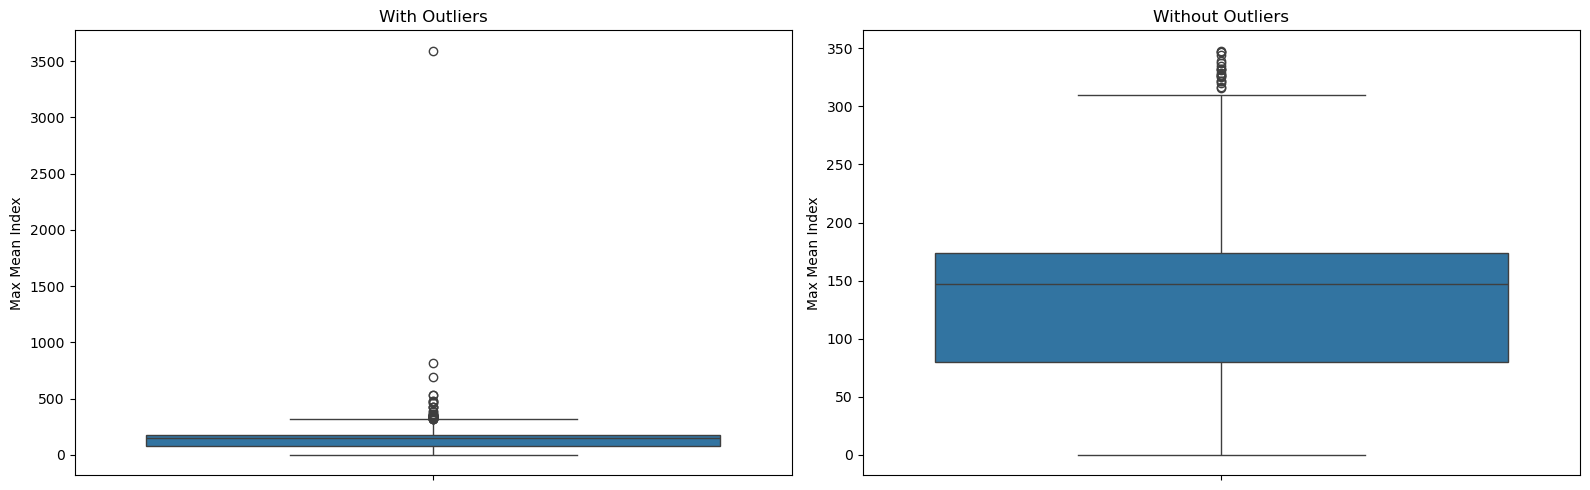

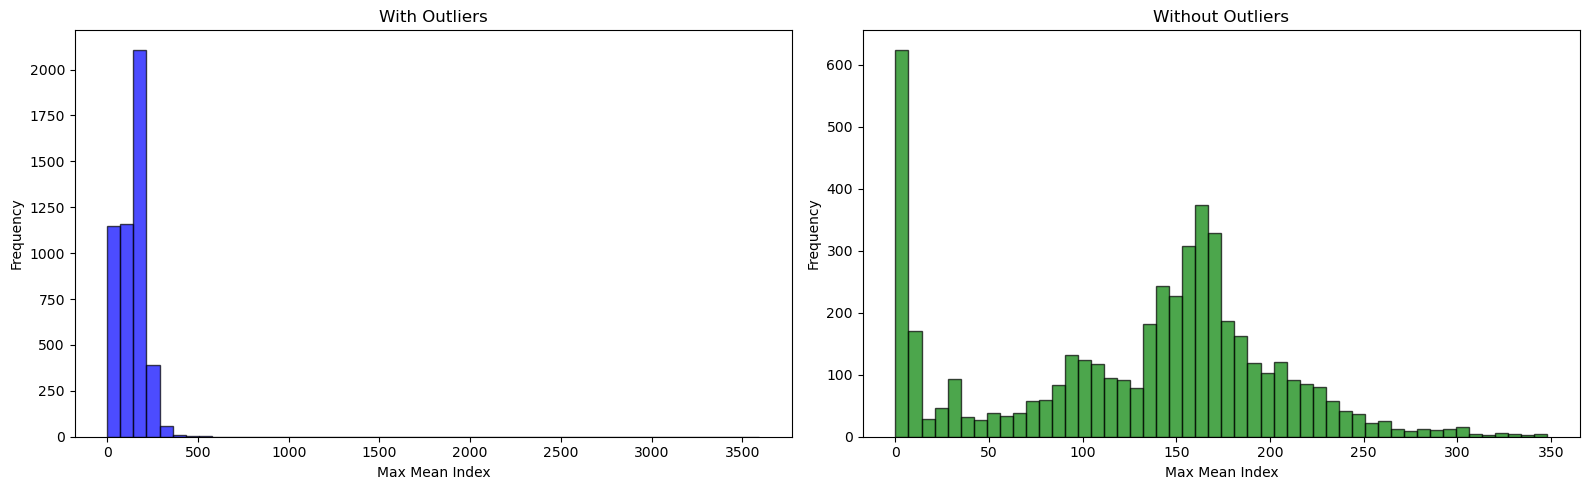

In [38]:
# plotting the distribution of the maximal position of kmer in genus sequence
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(16, 5))
# Plot with outliers
plt.subplot(1, 2, 1)
sns.boxplot(data=all_sequence_lengths)
plt.ylabel("Max Mean Index")
plt.title("With Outliers")

plt.subplot(1, 2, 2)
sns.boxplot(data=outlier_out_all_sequence_lengths)
plt.ylabel("Max Mean Index")
plt.title("Without Outliers")

plt.tight_layout()
plt.show()
# Plot histograms for the distributions
plt.figure(figsize=(16, 5))

# Histogram with outliers
plt.subplot(1, 2, 1)
plt.hist(all_sequence_lengths, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel("Max Mean Index")
plt.ylabel("Frequency")
plt.title("With Outliers")

# Histogram without outliers
plt.subplot(1, 2, 2)
plt.hist(outlier_out_all_sequence_lengths, bins=50, color='green', alpha=0.7, edgecolor='black')
plt.xlabel("Max Mean Index")
plt.ylabel("Frequency")
plt.title("Without Outliers")

plt.tight_layout()
plt.show()

In [41]:
len(taxa_kmer_abund_dict.keys())

4881

In [1]:
# Use a set to avoid redundant keys in filtered_taxa_all_positions
filtered_taxa_all_positions = list(taxa_kmer_abund_dict.keys())
# Precompute averages for all taxa in one loop
averages = []
for key in filtered_taxa_all_positions:
    index_array = taxa_kmer_abund_dict[key]["index_array"]
    # Flatten the subarrays and compute the mean directly using NumPy
    flattened = np.concatenate(index_array)
    averages.append(np.mean(flattened))

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(averages, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel('Average Index Array Value')
plt.ylabel('Frequency')
plt.title('Histogram of Average Index Array Values for Filtered Taxa')
plt.grid(axis='y', alpha=0.75)
plt.show()


# taxa with big positions of kmers
# here I plot the same thing
filtered_taxa_big_positions = [key for key, value in taxa_kmer_abund_dict.items() if any(np.max(subarray) > 300 for subarray in value["index_array"])]
#len(filtered_keys)
# Calculate the average of value["index_array"] for filtered taxa
averages = [
    np.mean([np.mean(subarray) for subarray in taxa_kmer_abund_dict[key]["index_array"]])
    for key in filtered_taxa_big_positions
]

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(averages, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel('Average Index Array Value')
plt.ylabel('Frequency')
plt.title('Histogram of Average Index Array Values for Filtered Taxa')
plt.grid(axis='y', alpha=0.75)
plt.show()




NameError: name 'taxa_kmer_abund_dict' is not defined

#### This shows that it is ok to discart all indexes that are above 300?

### Now I will load the Simera data

In [16]:
from Bio import SeqIO
#read cutadapt seqs from simera
amp_fasta = '../datasets/uchime_reference_dataset_16_10_2022/2022_10_26_chimera_reference_release/amplicons_from_primers_simera/gITS7___ITS4/20250325_182506/all_seqs_cutadapt.fa'  # Replace with the path to your FASTA file
amp_sequences = [(i.id,i.seq) for i in SeqIO.parse(amp_fasta, "fasta")]

print(f"Read {len(amp_sequences)} sequences from the FASTA file.")

Read 33778 sequences from the FASTA file.


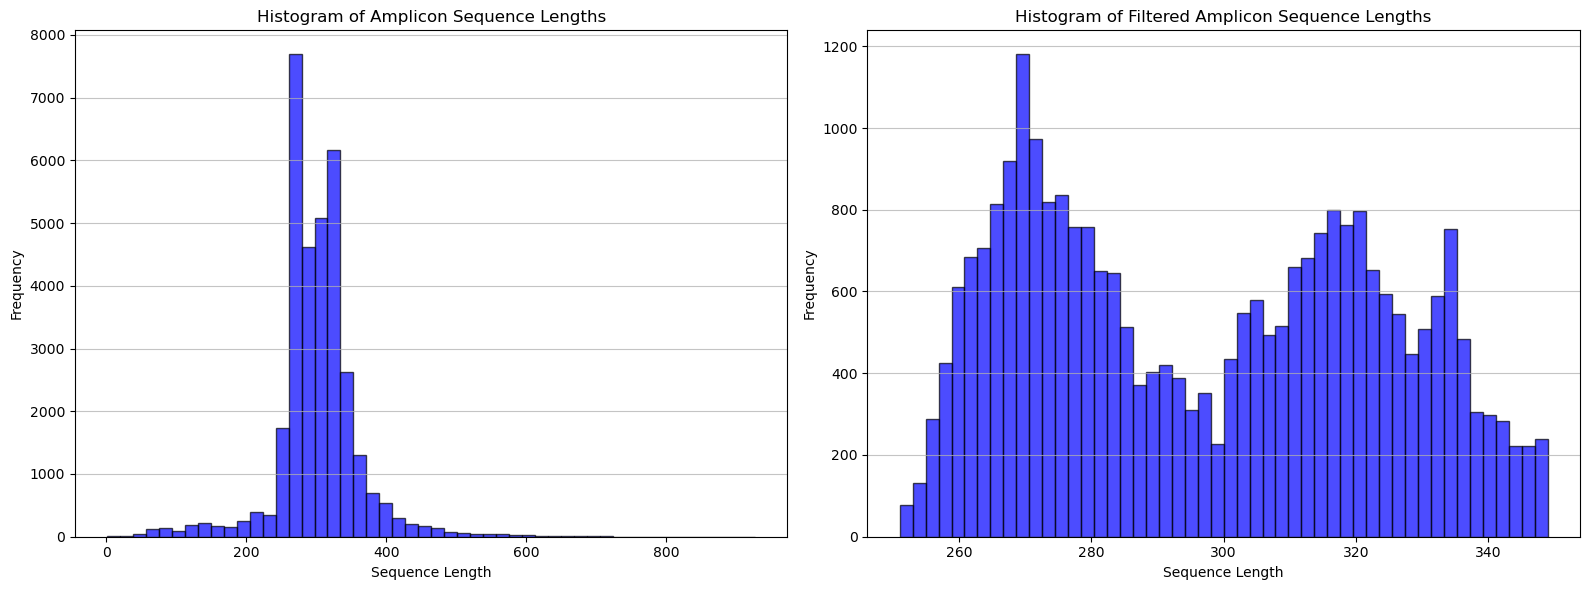

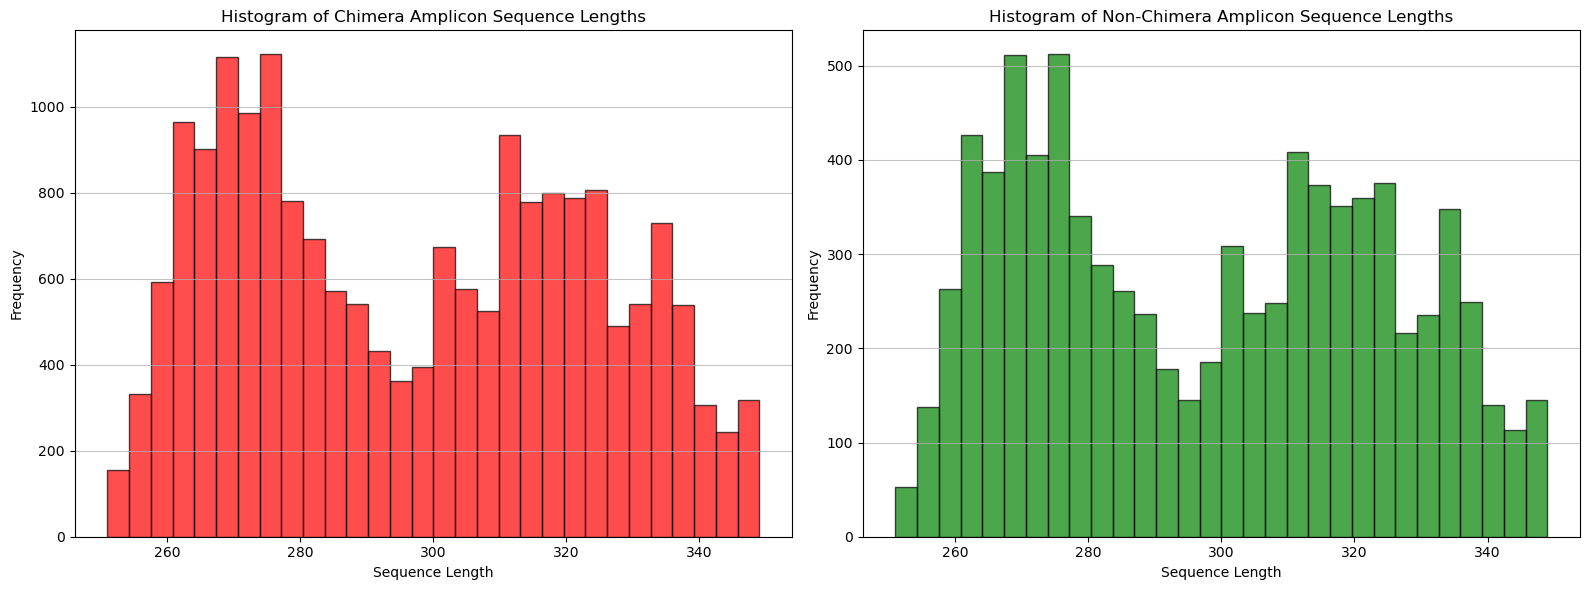

In [23]:
# from Simera fasta I should discard all sequences with length < 250 and > 350
# I ploted all simera read lengths and cut them with min_seq_length = 250 and max_seq_length = 350
import matplotlib.pyplot as plt

min_seq_length = 250
max_seq_length = 350

plt.figure(figsize=(16, 6))

# Subplot 1: Histogram of all sequence lengths
plt.subplot(1, 2, 1)
sequence_lengths = [len(seq[1]) for seq in amp_sequences if len(seq[1])]
plt.hist(sequence_lengths, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Histogram of Amplicon Sequence Lengths')
plt.grid(axis='y', alpha=0.75)

# Subplot 2: Histogram of filtered sequence lengths
plt.subplot(1, 2, 2)
filtered_lengths = [len(seq[1]) for seq in amp_sequences if min_seq_length < len(seq[1]) < max_seq_length]
plt.hist(filtered_lengths, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Histogram of Filtered Amplicon Sequence Lengths')
plt.grid(axis='y', alpha=0.75)

plt.tight_layout()
plt.show()

# Separate sequence lengths based on "chimera" in the ID
chimera_lengths = [len(seq[1]) for seq in amp_sequences if "chimera" in seq[0] and min_seq_length < len(seq[1]) < max_seq_length]
non_chimera_lengths = [len(seq[1]) for seq in amp_sequences if "chimera" not in seq[0] and min_seq_length < len(seq[1]) < max_seq_length]

# Create a new figure for the chimera and non-chimera histograms
plt.figure(figsize=(16, 6))

# Subplot 1: Histogram for "chimera" reads
plt.subplot(1, 2, 1)
plt.hist(chimera_lengths, bins=30, color='red', alpha=0.7, edgecolor='black')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Histogram of Chimera Amplicon Sequence Lengths')
plt.grid(axis='y', alpha=0.75)

# Subplot 2: Histogram for non-"chimera" reads
plt.subplot(1, 2, 2)
plt.hist(non_chimera_lengths, bins=30, color='green', alpha=0.7, edgecolor='black')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Histogram of Non-Chimera Amplicon Sequence Lengths')
plt.grid(axis='y', alpha=0.75)

plt.tight_layout()
plt.show()

# Filter sequences based on length
better_amp_sequences = [i for i in amp_sequences if min_seq_length < len(i[1]) < max_seq_length]

In [43]:
from collections import deque
from itertools import combinations

def extract_kmers(seq, k_size):
    """Optimized k-mer extraction using slicing."""
    if len(seq) < k_size:
        return set()
    return {seq[i:i + k_size] for i in range(len(seq) - k_size + 1)}

k_count = 9  # 9-mers
stop_after = 0
part_similarities_for_all_taxa = {}

taxa_kmers_sets = {key: set(taxa_kmers["kmer_array"]) for key, taxa_kmers in taxa_kmer_abund_dict.items()}

for n, query_read in enumerate(better_amp_sequences):
    if "chimera" not in query_read[0]:
        continue
    stop_after += 1
    if stop_after > 1000:
        break

    seq = str(query_read[1])
    part_number = 7
    seq_length = len(seq)
    part_length = seq_length / part_number
    parts = [seq[round(part_length * p):round(part_length * (p + 1))] for p in range(part_number)]

    kmers_in_parts = {}
    for p_num, part in enumerate(parts):
        kmers = extract_kmers(part, k_count)  # Use the optimized k-mer extraction

        best_taxa_for_this_part = None
        best_taxa_score = 0

        for key, taxa_kmers in taxa_kmer_abund_dict.items():
            taxa_kmers_set = taxa_kmers_sets[key]  # Precompute the set once
            common_kmers = kmers & taxa_kmers_set
            intersection = len(common_kmers)
            union = len(kmers) + len(taxa_kmers_set) - intersection  # Faster union computation
            score = intersection / union if union != 0 else 0

            if score > best_taxa_score:
                best_taxa_score = score
                best_taxa_for_this_part = key

        kmers_in_parts[p_num + 1] = best_taxa_for_this_part
        if best_taxa_for_this_part is None:
            print(f"Best taxa for part {p_num + 1} is None. Check the seq: {query_read[0]},{seq}")
            sys.exit()

    part_similarities = {}
    for part1, part2 in combinations(range(1, part_number + 1), 2):
        taxa1 = kmers_in_parts.get(part1)
        taxa2 = kmers_in_parts.get(part2)

        #if taxa1 is None or taxa2 is None:
            #continue

        taxa1_kmers = taxa_kmers_sets[taxa1]
        taxa2_kmers = taxa_kmers_sets[taxa2]
        kmers1 = taxa1_kmers
        kmers2 = taxa2_kmers

        intersection = len(kmers1 & kmers2)  # Faster set intersection
        union = len(kmers1 | kmers2)  # Faster set union
        similarity = intersection / union if union != 0 else 0  # Jaccard similarity

        part_similarities[(part1, part2)] = similarity
    #print(query_read[0], part_similarities,sep="\n")
    part_similarities_for_all_taxa[query_read[0]] = part_similarities
    

In [44]:
from collections import deque
from itertools import combinations

def extract_kmers(seq, k_size):
    """Optimized k-mer extraction using slicing."""
    if len(seq) < k_size:
        return set()
    return {seq[i:i + k_size] for i in range(len(seq) - k_size + 1)}

k_count = 9  # 9-mers
stop_after = 0
dva_part_similarities_for_all_taxa = {}

taxa_kmers_sets = {key: set(taxa_kmers["kmer_array"]) for key, taxa_kmers in taxa_kmer_abund_dict.items()}

for n, query_read in enumerate(better_amp_sequences):
    if "chimera" in query_read[0]:
        continue
    stop_after += 1
    if stop_after > 1000:
        break

    seq = str(query_read[1])
    part_number = 7
    seq_length = len(seq)
    part_length = seq_length / part_number
    parts = [seq[round(part_length * p):round(part_length * (p + 1))] for p in range(part_number)]

    kmers_in_parts = {}
    for p_num, part in enumerate(parts):
        kmers = extract_kmers(part, k_count)  # Use the optimized k-mer extraction

        best_taxa_for_this_part = None
        best_taxa_score = 0

        for key, taxa_kmers in taxa_kmer_abund_dict.items():
            taxa_kmers_set = taxa_kmers_sets[key]  # Precompute the set once
            common_kmers = kmers & taxa_kmers_set
            intersection = len(common_kmers)
            union = len(kmers) + len(taxa_kmers_set) - intersection  # Faster union computation
            score = intersection / union if union != 0 else 0

            if score > best_taxa_score:
                best_taxa_score = score
                best_taxa_for_this_part = key

        kmers_in_parts[p_num + 1] = best_taxa_for_this_part
        if best_taxa_for_this_part is None:
            print(f"Best taxa for part {p_num + 1} is None. Check the seq: {query_read[0]},{seq}")
            sys.exit()

    part_similarities = {}
    for part1, part2 in combinations(range(1, part_number + 1), 2):
        taxa1 = kmers_in_parts.get(part1)
        taxa2 = kmers_in_parts.get(part2)

        #if taxa1 is None or taxa2 is None:
            #continue

        taxa1_kmers = taxa_kmers_sets[taxa1]
        taxa2_kmers = taxa_kmers_sets[taxa2]
        kmers1 = taxa1_kmers
        kmers2 = taxa2_kmers

        intersection = len(kmers1 & kmers2)  # Faster set intersection
        union = len(kmers1 | kmers2)  # Faster set union
        similarity = intersection / union if union != 0 else 0  # Jaccard similarity

        part_similarities[(part1, part2)] = similarity
    #print(query_read[0], part_similarities,sep="\n")
    dva_part_similarities_for_all_taxa[query_read[0]] = part_similarities
    

In [45]:
# Calculate average similarity for part_similarities_for_all_taxa
part_similarities_avg = sum(
    similarity for similarities in part_similarities_for_all_taxa.values() for similarity in similarities.values()
) / sum(len(similarities) for similarities in part_similarities_for_all_taxa.values())

# Calculate average similarity for dva_part_similarities_for_all_taxa
dva_part_similarities_avg = sum(
    similarity for similarities in dva_part_similarities_for_all_taxa.values() for similarity in similarities.values()
) / sum(len(similarities) for similarities in dva_part_similarities_for_all_taxa.values())

# Compare the averages
print(f"Average similarity in part_similarities_for_all_taxa: {part_similarities_avg}")
print(f"Average similarity in dva_part_similarities_for_all_taxa: {dva_part_similarities_avg}")

if part_similarities_avg > dva_part_similarities_avg:
    print("part_similarities_for_all_taxa generally has higher values.")
elif part_similarities_avg < dva_part_similarities_avg:
    print("dva_part_similarities_for_all_taxa generally has higher values.")
else:
    print("Both have similar average values.")

Average similarity in part_similarities_for_all_taxa: 0.1724653096418993
Average similarity in dva_part_similarities_for_all_taxa: 0.169429046547129
part_similarities_for_all_taxa generally has higher values.


In [49]:
# Calculate average similarity for part_similarities_for_all_taxa
part_similarities_avg = sum(
    similarity for similarities in part_similarities_for_all_taxa.values() for similarity in similarities.values()
) / sum(len(similarities) for similarities in part_similarities_for_all_taxa.values())

# Calculate average similarity for dva_part_similarities_for_all_taxa
dva_part_similarities_avg = sum(
    similarity for similarities in dva_part_similarities_for_all_taxa.values() for similarity in similarities.values()
) / sum(len(similarities) for similarities in dva_part_similarities_for_all_taxa.values())

# Compare the averages
print(f"Average similarity in part_similarities_for_all_taxa: {part_similarities_avg}")
print(f"Average similarity in dva_part_similarities_for_all_taxa: {dva_part_similarities_avg}")

if part_similarities_avg > dva_part_similarities_avg:
    print("part_similarities_for_all_taxa generally has higher values.")
elif part_similarities_avg < dva_part_similarities_avg:
    print("dva_part_similarities_for_all_taxa generally has higher values.")
else:
    print("Both have similar average values.")

Average similarity in part_similarities_for_all_taxa: 0.1703093960921129
Average similarity in dva_part_similarities_for_all_taxa: 0.18813296519962958
dva_part_similarities_for_all_taxa generally has higher values.


In [48]:
dva_part_similarities_for_all_taxa

{'Hyaloscyphaceae_sp|LC085197|SH0990349.09FU|reps|k__Fungi;p__Ascomycota;c__Leotiomycetes;o__Helotiales;f__Hyaloscyphaceae;g__unidentified;s__Hyaloscyphaceae_sp_1_1_1054': {(1,
   2): 0.029045643153526972,
  (1, 3): 0.0,
  (1, 4): 0.06506849315068493,
  (1, 5): 0.031055900621118012,
  (1, 6): 0.025380710659898477,
  (1, 7): 0.0,
  (2, 3): 0.0,
  (2, 4): 0.04285714285714286,
  (2, 5): 0.008403361344537815,
  (2, 6): 0.03773584905660377,
  (2, 7): 0.010256410256410256,
  (3, 4): 0.0,
  (3, 5): 0.0,
  (3, 6): 0.0,
  (3, 7): 0.0,
  (4, 5): 0.034129692832764506,
  (4, 6): 0.02976190476190476,
  (4, 7): 0.0,
  (5, 6): 0.043010752688172046,
  (5, 7): 0.0,
  (6, 7): 0.0},
 'Microbotryomycetes_sp|JN889747|SH1067691.09FU|reps|k__Fungi;p__Basidiomycota;c__Microbotryomycetes;o__unidentified;f__unidentified;g__unidentified;s__Microbotryomycetes_sp_1_2_53075': {(1,
   2): 0.0,
  (1, 3): 0.0,
  (1, 4): 0.0,
  (1, 5): 0.0,
  (1, 6): 0.0,
  (1, 7): 0.0,
  (2, 3): 0.21081081081081082,
  (2, 4): 0.214876